<h1>Digit Recognization With Tensorflow</h1>

<h2 style="font-size: 20px;">Import Necessary Libraries and packages</h2>

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import callbacks
from google.colab import drive
from tensorflow.keras import layers
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.8.0


<h2 style="font-size: 20px;">Setting The Notebook</h2>

In [3]:
# Setting the graph style
plt.rc('figure', autolayout=True)
plt.rc(
    'axes', titleweight='bold', 
    titlesize=20, labelweight=700,
    labelsize=13
    )
plt.rc('font', size=15)

def set_seeds(seed: int=0):
    """Sets the Seed into order to get the same result on every code run"""
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ["TF_DETERMINISTIC"] = str(seed)
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# Call the set_seeds with default parameter
set_seeds()

try:
    tfu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    stratagy = tf.distribute.TPUStrategy(tfu)
except ValueError:
    stratagy = tf.distribute.get_strategy()
print(f"Number of Accelerator: {stratagy.num_replicas_in_sync}")

Number of Accelerator: 1


<h2 style="font-size: 20px;">Above Dataset</h2>
<p style="font-size: 15px;">
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
</p>

<h2 style="font-size: 20px;">Load Csv File Into Pandas DataFrame</h2>

In [4]:
# Mount google files
drive.mount('/gdrive')

# list the files from drive
folder_path = '../gdrive/MyDrive/Datasets/MNIST_data'
os.listdir(folder_path)

Mounted at /gdrive


['train.csv', 'test.csv', 'sample_submission.csv']

In [5]:
# Data Path
train_data_path = folder_path + '/train.csv'
test_data_path = folder_path + '/test.csv'

# Loading dataset into pandas 
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

<h2 style="font-size: 20px;">View The Dataframe</h2>

In [6]:
# First Rows in the train data
print(train_df.shape)
train_df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# First Rows in the test data
print(test_df.shape)
test_df.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2 style="font-size: 20px;">Train Data Split Into Train and Validation data</h2>

In [8]:
mask = np.random.randn(len(train_df)) > 0.8
train_data = train_df[mask]
valid_data = train_df[~mask]
print(f"Train_data shape: {train_data.shape}\nValid_data: {valid_data.shape}")

Train_data shape: (8828, 785)
Valid_data: (33172, 785)


<h2 style="font-size: 20px;">Create Dataset Generator</h2>

In [9]:
class DatasetGenerator:
    def __init__(self, batch_size: int = 64, shuffle: int = False, epoch: int = 10) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.epoch = epoch

    def __call__(self, df: pd.DataFrame) -> any:
        if self.shuffle:
            df_ = tf.constant([
                row[1:].values / 255
                for _, row in df.iterrows()
                ])
            df_ = tf.reshape(df_, [len(df), 28, 28])
            labels = df.iloc[:, 0]
            data = tf.data.Dataset.from_tensor_slices((df_, labels)).batch(self.batch_size).shuffle(1000)
        else:
            df_ = tf.constant([
                row.values.reshape(28, 28) /255
                for _, row in df.iterrows()
                ])
            df_ = tf.reshape(df_, [len(df), 28, 28])
            data = tf.data.Dataset.from_tensor_slices((df_)).batch(self.batch_size)
        return data

<h2 style="font-size: 20px;">Convert The Data To tensor</h2>

In [10]:
# Change the dataframes to generator 
train_data = DatasetGenerator(shuffle=True)(train_data)
validation_data = DatasetGenerator(shuffle=True)(valid_data)
test_dataset = DatasetGenerator()(test_df)

<h2 style="font-size: 20px;">Exploring Datasets</h2>

In [11]:
# Exploring One of the image in the train_dataset generator
img, label = next(iter(train_data))

In [12]:
print("image Datatype: ", type(img[0]))
print("label data type: ", type(label[1]))
print("label: ", set(label.numpy()))

image Datatype:  <class 'tensorflow.python.framework.ops.EagerTensor'>
label data type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
label:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [13]:
# For exploratory purpose change the image to numpy array
np_img = np.array(img)
IMG_SHAPE = np_img.shape
print("Image shape: ", IMG_SHAPE)

Image shape:  (64, 28, 28)


<h2 style="font-size: 20px;">Digits Visualization</h2>

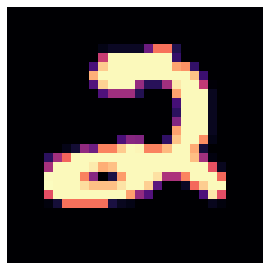

In [14]:
# Visualizing of the one image in the test_dataset
img = next(iter(test_dataset))
cmap = plt.get_cmap('magma')
plt.imshow(tf.squeeze(img[0]), cmap=cmap)
plt.axis('off')
plt.show()


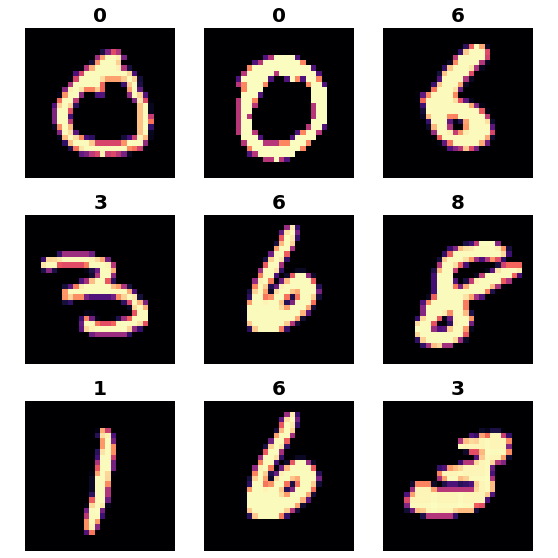

In [15]:
# Create Subplot instance
fig, ax = plt.subplots(figsize=(8, 8))

# Number of columns and rows
NROW = 3
NCOL = 3

# loop over the range of NROW * NCOL starting from 1
for i in range(1, NROW * NROW + 1):
    fig.add_subplot(NROW, NCOL, i)

    # Get the image from the generated index
    img, label = next(iter(train_data))

    # Plot it
    plt.imshow(tf.squeeze(img[0]), 
        cmap=cmap
        )
    plt.axis('off')
    plt.title(label[0].numpy())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_axis_off()

<h2 style="font-size: 20px;">Modeling</h2>

In [16]:
train_nrow = np.array(list(train_data.as_numpy_iterator())).shape[0]
test_nrow = np.array(list(validation_data.as_numpy_iterator())).shape[0]
training_size = train_nrow - test_nrow
BATCH_SIZE_PER_REPLICA = 32
batch_size = BATCH_SIZE_PER_REPLICA * stratagy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = test_nrow // batch_size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


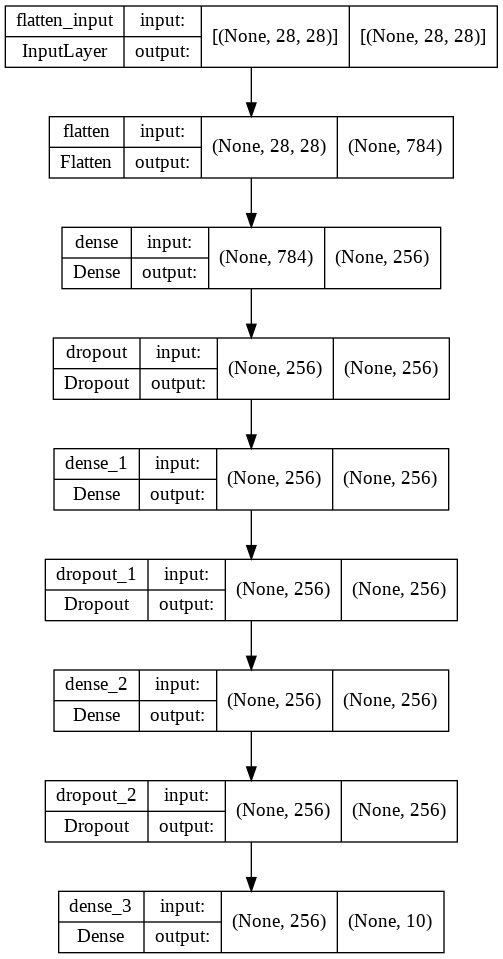

In [17]:

def build_model(input_shape, eager: bool = False):
    """Create a Keras Sequential and complie it"""
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))

    model.add(layers.Dense(units=256, activation='relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.Dense(units=256, activation='relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.Dense(units=256, activation='relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.2))



    model.add(layers.Dense(units=10, activation='softmax'))

    if eager:
        model.compile(
            optimizer='adam',
            loss='SparseCategoricalCrossentropy',
            metrics=['acc'],
            run_eagerly=True

        )
    else:
        model.compile(
            optimizer='adam',
            loss='SparseCategoricalCrossentropy',
            metrics=['acc'],
        )
    return model

# Model instance
model = build_model(IMG_SHAPE[1:])

# Plot the model
dot_image_file = '/tmp/model_1.png'
keras.utils.plot_model(model, to_file=dot_image_file, show_shapes=True)

In [18]:
# Initialize the EarlyStopping class: early_stopping
early_stopping = callbacks.EarlyStopping(
    patience=1,
    min_delta=0.01,
    restore_best_weights=True
    
)

Callback to save the Keras model or model weights at some frequency

In [19]:
checkpoint_filepath = "/tmp/checkpoints"

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Reduce learning rate when a metric has stopped improving

In [20]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=0, min_lr=0.001, mode='auto', verbose=1)

In [21]:

# Fit the model
with stratagy.scope():
    model = build_model(IMG_SHAPE[1:])

history = model.fit(
    train_data, 
    validation_data=validation_data, 
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    batch_size=batch_size,
    validation_steps=validation_steps 
    )

Epoch 1/15
138/138 [==============================] - 2s 11ms/step - loss: 1.0433 - acc: 0.6500 - val_loss: 0.3508 - val_acc: 0.8877 - lr: 0.0010
Epoch 2/15
138/138 [==============================] - 1s 9ms/step - loss: 0.4466 - acc: 0.8592 - val_loss: 0.2692 - val_acc: 0.9092 - lr: 0.0010
Epoch 3/15
138/138 [==============================] - 1s 9ms/step - loss: 0.3464 - acc: 0.8959 - val_loss: 0.2571 - val_acc: 0.9189 - lr: 0.0010
Epoch 4/15
138/138 [==============================] - 1s 10ms/step - loss: 0.2854 - acc: 0.9094 - val_loss: 0.1973 - val_acc: 0.9346 - lr: 0.0010
Epoch 5/15
138/138 [==============================] - 1s 10ms/step - loss: 0.2551 - acc: 0.9212 - val_loss: 0.1875 - val_acc: 0.9346 - lr: 0.0010


In [22]:
# Training without early_stopping callback
# Fit the model
with stratagy.scope():
    model = build_model(IMG_SHAPE[1:])

history = model.fit(
    train_data, 
    validation_data=validation_data,
    epochs=20,
    callbacks=[model_checkpoint_callback, reduce_lr],
    # Made same improve with these two code
    batch_size=batch_size,
    validation_steps=validation_steps
    )

Epoch 1/20
138/138 [==============================] - 2s 10ms/step - loss: 1.0481 - acc: 0.6454 - val_loss: 0.3366 - val_acc: 0.9014 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 0.4504 - acc: 0.8569 - val_loss: 0.2643 - val_acc: 0.9209 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 2s 11ms/step - loss: 0.3348 - acc: 0.8931 - val_loss: 0.2158 - val_acc: 0.9287 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 1s 9ms/step - loss: 0.2878 - acc: 0.9114 - val_loss: 0.2170 - val_acc: 0.9258 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 1s 10ms/step - loss: 0.2488 - acc: 0.9222 - val_loss: 0.1745 - val_acc: 0.9463 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 1s 10ms/step - loss: 0.2184 - acc: 0.9317 - val_loss: 0.2510 - val_acc: 0.9346 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 1s 10ms/step - loss: 0.1976 - acc: 0.9399 - val_loss: 0.2004 - val_acc:

In [23]:
# Construct a dataframe with loss and accuracy score
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,acc,val_loss,val_acc,lr
0,1.048141,0.645446,0.336632,0.901367,0.001
1,0.450444,0.856932,0.264322,0.920898,0.001
2,0.334812,0.893068,0.215826,0.928711,0.001
3,0.287818,0.911418,0.217018,0.925781,0.001
4,0.248836,0.922179,0.174497,0.946289,0.001


<h2 style="font-size: 20px;">Visualizing Train And Validation Loss And Accuracy</h2>

In [24]:
def metric_vis(train: str, val: str, ax: plt.axis) -> None:

    fig1 = history_df[train].plot(c='pink', ax=ax, marker="x")
    fig2 = history_df[val].plot(c='skyblue', ax=ax, marker="o")
    ax.set_ylabel(f"{train} Score")
    ax.set_xlabel("Epoch/Iteration")
    ax.set_title(f"Train And Validation {train}".title())
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend([f'{train}', f"{val}"])

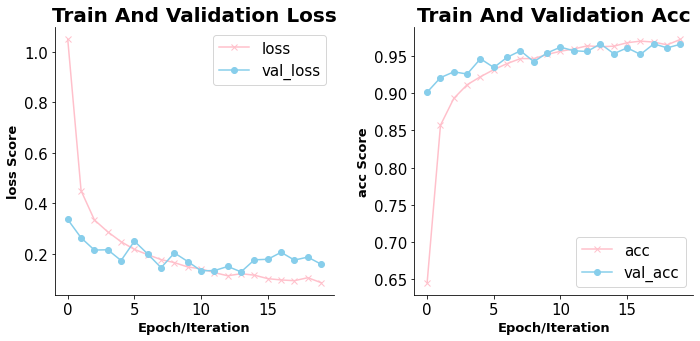

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
metric_vis("loss", 'val_loss', ax=ax[0])
metric_vis("acc", 'val_acc', ax=ax[1])

<h2 style="font-size: 20px;">Submission</h2>

In [26]:
# Make predictions
prob  = model.predict(test_dataset)
# Get the highest value from probability
pred = tf.argmax(prob, 1)

In [27]:
submission=pd.read_csv(folder_path + '/sample_submission.csv')
submission['Label']=pred
submission.to_csv('prediction12.csv', index=False)